# TEXT MINING PROJECT

Organization - Each newsgroup file in the bundle represents a single newsgroup - Each message in a file is the text of some newsgroup document that was posted to that newsgroup.

This is a list of the 20 newsgroups:

- comp.graphics
- comp.os.ms-windows.misc
- comp.sys.ibm.pc.hardware
- comp.sys.mac.hardware
- comp.windows.x rec.autos
- rec.motorcycles
- rec.sport.baseball
- rec.sport.hockey sci.crypt
- sci.electronics
- sci.med
- sci.space
- misc.forsale talk.politics.misc
- talk.politics.guns
- talk.politics.mideast talk.religion.misc
- alt.atheism
- soc.religion.christian

In this kernel we will perform the following task:




1.   Text classification
2.   Topic modeling
3.   Text summarization





In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import operator
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize,word_tokenize
nltk.download('averaged_perceptron_tagger')
Stopwords = set(stopwords.words('english'))
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score
import pickle
from nltk.translate.bleu_score import sentence_bleu

#topic modeling
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# I. TEXT CLASSIFICATION

In [5]:
#Load data
!unzip train.csv.zip
train_data = pd.read_csv('train.csv', delimiter=',')
train_data.head()

Archive:  train.csv.zip
  inflating: train.csv               


,id,message,topic
0,0,From: lerxst@wam.umd.edu (where's my thing)\r\...,7
1,1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,3,From: jgreen@amber (Joe Green)\r\nSubject: Re:...,1
4,4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14


In [6]:
train_data.shape

(11314, 3)

In [8]:
train_data.topic.value_counts()

10    600
15    599
8     598
9     597
11    595
13    594
7     594
14    593
5     593
12    591
2     591
3     590
6     585
1     584
4     578
17    564
16    546
0     480
18    465
19    377
Name: topic, dtype: int64

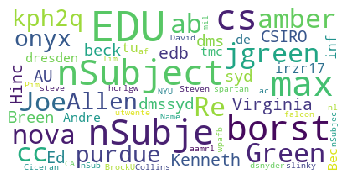

In [9]:
#data viz

t=train_data.message[train_data.topic==1]
wordcloud = WordCloud(
                          background_color='white',
                          min_font_size=10,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         )
fig = plt.figure(1)
plt.imshow(wordcloud.generate (str(t)))
plt.axis('off')
plt.show()

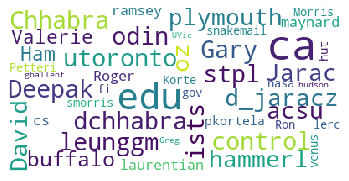

In [10]:
t=train_data.message[train_data.topic==10]
plt.imshow(wordcloud.generate (str(t)))
plt.axis('off')
plt.show()

In [0]:
#split data
X = train_data[['id', 'message']]
y = train_data['topic']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [0]:
#Clean & tokenize data
def tokens_clean(Document):
    """
    This is a tokenizer that will be used when transforming the message to a Bag of Words after cleansing.
    """
    Document = re.sub('[^a-zA-Z]',' ',Document)
    Document = Document.lower()
    Document = word_tokenize(Document)
    porter_stemmer=nltk.PorterStemmer()
    Document = [porter_stemmer.stem(word) for word in Document if not word in set(stopwords.words('english'))]
    return Document

## 1) TF-IDF model + XGboost

In [0]:
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokens_clean, max_df=0.3, min_df=0.001, max_features=100000)),
    ('clf',     XGBClassifier(objective='multi:softmax', n_estimators=100, num_class=20, learning_rate=0.075, colsample_bytree=0.7, subsample=0.8, eval_metric='merror')
  ),
])


text_clf.fit(X_train.message, y_train)
predictions = text_clf.predict(X_test.message)

In [23]:
#model evaluation
print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions, average='weighted'))
print(confusion_matrix(y_test, predictions))

Accuracy: 0.7920471281296023
Precision: 0.8070636357429132
[[112   2   0   0   0   1   1   0   0   0   1   1   1   1   2   9   1   1
    4  23]
 [  0 115  14  10   5   8   2   0   0   1   0   0  13   1   5   0   0   0
    1   0]
 [  0   8 144  12   0   6   2   0   0   0   0   1  11   0   3   0   2   0
    1   0]
 [  0  11  15  99   5   2   7   4   1   0   0   2   7   0   1   0   4   0
    0   0]
 [  0   6   1  15 139   4   6   1   0   0   0   1  15   0   1   0   0   0
    0   0]
 [  0   6   9   6   0 157   1   0   1   1   0   0   3   2   4   0   0   0
    0   0]
 [  0   1   2  12   4   1 124   2   3   0   1   0  12   1   3   1   1   0
    1   0]
 [  0   1   2   7   4   0   1 141   3   2   0   1  14   2   2   1   1   0
    1   0]
 [  0   2   0   1   1   1   3   2 171   0   0   0   5   0   1   1   0   0
    1   0]
 [  1   0   1   1   0   0   1   0   0 160   9   0  10   1   0   0   0   0
    1   1]
 [  0   0   0   0   1   0   0   0   0   7 149   0   5   0   0   0   0   0
    0   0]
 [  0 

## TEST XGBOOST ON FIRST ROW

In [49]:
print('********************** MESSAGE: ********************\n\n'+ X_test.message[9959]+ ' *************************************************\n\nTrue category: ', y_test[9959],'\nPredicted category: ',text_clf.predict([X_test.message[9959]])) 
    

********************** MESSAGE: ********************

From: turpin@cs.utexas.edu (Russell Turpin)
Subject: Re: Science and methodology (was: Homeopathy ... tradition?)
Organization: CS Dept, University of Texas at Austin
Lines: 18
Distribution: inet
NNTP-Posting-Host: im4u.cs.utexas.edu

-*-----
In article <1993Apr15.150550.15347@ecsvax.uncecs.edu> ccreegan@ecsvax.uncecs.edu (Charles L. Creegan) writes:
> What about Kekule's infamous derivation of the idea of benzene rings
> from a daydream of snakes in the fire biting their tails?  Is this
> specific enough to count?  Certainly it turns up repeatedly in basic
> phil. of sci. texts as an example of the inventive component of
> hypothesizing. 

I think the question is: What is extra-scientific about this?  

It has been a long time since anyone has proposed restrictions on
where one comes up with ideas in order for them to be considered
legitimate hypotheses.  The point, in short, is this: hypotheses and
speculation in science may come 

## 2) word2vec model + logistic regression

## a) Data modeling (prepare tokens for each sentence) + fit the model

In [0]:
#word2vec
#prepare data
sentences = []
texts=[]
# Go through each text in turn
for ii in range(train_data.message.shape[0]):
    sentences = [re.sub(pattern=r'[\!"#$%&\*+,-./:;<=>?@^_`()|~=]', 
                        repl='', 
                        string=x
                       ).strip().split(' ') for x in train_data.message[ii].split('\n') 
                      if not x.endswith('writes:')]
    sentences = [x for x in sentences if x != ['']]
    texts.append(sentences)
    
all_sentences = []
for text in texts:
    all_sentences += text

In [0]:
model = Word2Vec(all_sentences,size=200, workers=2, window=5,iter=30)      

In [57]:
len(model.wv.vocab)


33558

In [58]:
trainvect=[]
n=int(11314*0.7)
for text in texts[:n]:
  text_vect=0
  nword=0
  for sent in text:
    for word in sent:
        if word in model.wv.vocab:
            nword+=1
            text_vect+=model[word]
  trainvect.append(text_vect/nword)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [59]:
testvect=[]
n=int(11314*0.7)
for text in texts[n:]:
  text_vect=0
  nword=0
  for sent in text:
    for word in sent:
        if word in model.wv.vocab:
            nword+=1
            text_vect+=model[word]
  testvect.append(text_vect/nword)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


## b) Classification using word2vec

In [60]:
clf=LogisticRegression(solver='liblinear')
clf.fit(trainvect, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
predictions=clf.predict(testvect)

In [62]:
#model evaluation
print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions, average='weighted'))
print(confusion_matrix(y_test, predictions))

Accuracy: 0.05184094256259205
Precision: 0.05383111562321546
[[ 6 10  4 12  8  7  7 12 11  6 15  8 12  7  9 12  2  8  1  3]
 [ 5  7  6 18  8  5 13 12  9  5 14 12  8  9 14  6  9 12  1  2]
 [ 3  7  9 13  9 12  6 11 11 10 19 10  9 13 14  9  7 14  2  2]
 [ 3  6  5  9  9  3  8  7 11  5 15 10  9 12 11 10 11  9  3  2]
 [ 2  8 10 11  8 11 12  8  8  8 15 12 10 13  8 20  6 10  4  5]
 [ 4  9  8 12  6 11 11 16 10  9 12 11 15 11 17 18  5  2  2  1]
 [ 1  5  7 16 11  8  8  8  9  4 21  9  7 12  9 13  8  6  4  3]
 [ 4  8  8 16  8 10 12 12 13  6 17  7 10  9 12 10  5 12  2  2]
 [ 5  5  8 14  7  9 14  9  8  8 14 14 14 10 16 23  2  5  3  1]
 [ 7  6  7 15 12  5 10 11 12  9  6 10 10 14 13 15  2 16  4  2]
 [ 2  6  3 12  7 12  9 11 12  4 18  8  8  8  8 12  6 10  3  3]
 [ 2 11  5 19  8  7  8 14 11  7 10  7 11 10 10 13 10 10  1  1]
 [ 3  8 14 11  7 13 17  6 12  6 14  6  6 11  7  3  2  8  3  4]
 [ 3 10 12 23  7 10 19 14 10  7 17  7  7  7 12 20  4 12  5  1]
 [ 2  8  5 13  7 11  4 11  7  9 10 10 11  8  9 10  8 13  

# II. TOPIC MODELING

In [0]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print( "Topic %d:" % (topic_idx) )
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

## 1) LDA

In [0]:
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(tokenizer=tokens_clean, max_df=0.3, min_df=0.001, max_features=100000)
tf = tf_vectorizer.fit_transform(train_data.message)
tf_feature_names = tf_vectorizer.get_feature_names()


In [0]:
no_topics = 20
no_top_words = 10

In [69]:
# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50,random_state=0).fit(tf)

display_topics(lda, tf_feature_names, no_top_words)


Topic 0:
card driver video monitor mous bu port problem mode bit
Topic 1:
gun control weapon state scsi firearm crime law ide rate
Topic 2:
peopl god say think believ christian make thing us time
Topic 3:
drive system mac disk do mb comput window appl thank
Topic 4:
x n ibm de output tu c col rule p
Topic 5:
water font mcgill nuclear cool eo ncsu sg tower alan
Topic 6:
space nasa gov orbit launch access center research earth year
Topic 7:
w r p u g c b k v q
Topic 8:
uk keith co moral object scienc cs utexa frank atheism
Topic 9:
go year think time good last well game look back
Topic 10:
key encrypt chip secur clipper govern de system public law
Topic 11:
pitt food health medic gordon bank diseas msg cs patient
Topic 12:
printer mil hp ti navi print ra rose dseg jason
Topic 13:
ax max q f g v p u b r
Topic 14:
armenian turkish peopl said presid mr greek war turk govern
Topic 15:
x file window program mail version imag c avail inform
Topic 16:
israel isra jew arab columbia jewish kill r

In [0]:
topic_values = lda.transform(tf)
train_data['TOPIC_LDA'] = topic_values.argmax(axis=1)

In [71]:
train_data.head(10)

,id,message,topic,TOPIC_LDA
0,0,From: lerxst@wam.umd.edu (where's my thing)\r\...,7,19
1,1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,3
2,2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,3
3,3,From: jgreen@amber (Joe Green)\r\nSubject: Re:...,1,19
4,4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,15
5,5,From: dfo@vttoulu.tko.vtt.fi (Foxvog Douglas)\...,16,1
6,6,From: bmdelane@quads.uchicago.edu (brian manni...,13,9
7,7,From: bgrubb@dante.nmsu.edu (GRUBB)\r\nSubject...,3,1
8,8,From: holmes7000@iscsvax.uni.edu\r\nSubject: W...,2,15
9,9,From: kerr@ux1.cso.uiuc.edu (Stan Kerr)\r\nSub...,4,3


## 2) NMF

In [0]:
# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokens_clean, max_df=0.3, min_df=0.001, max_features=100000)
tfidf = tfidf_vectorizer.fit_transform(train_data.message)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [73]:
# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
god christian jesu bibl believ faith exist christ say peopl
Topic 1:
window file do ms program run mous driver manag win
Topic 2:
game team player play win hockey season score year nhl
Topic 3:
key encrypt chip clipper escrow secur govern algorithm crypto secret
Topic 4:
drive scsi mb ide disk card hard control floppi bu
Topic 5:
gun firearm weapon crime crimin law handgun control peopl polic
Topic 6:
pitt geb gordon bank cs cadr dsl jxp chastiti intellect
Topic 7:
car dealer price mile driver drive insur speed k saturn
Topic 8:
nasa gov space larc jpl orbit gsfc jsc baalk center
Topic 9:
armenian turkish armenia argic serdar turk turkey genocid zuma soviet
Topic 10:
israel isra arab jew palestinian lebanes boni polici jewish peac
Topic 11:
keith moral caltech livesey sgi solntz wpd object cco jon
Topic 12:
ohio magnu state ac magnusug ci drug ryan bottom scharfi
Topic 13:
uk ac co dc mathew manti ed cam demon brunel
Topic 14:
cleveland cwru freenet in reserv western po case u

In [0]:
topic_values = lda.transform(tfidf)
train_data['TOPIC_NMF'] = topic_values.argmax(axis=1)

In [75]:
train_data.head(10)

,id,message,topic,TOPIC_LDA,TOPIC_NMF
0,0,From: lerxst@wam.umd.edu (where's my thing)\r\...,7,19,19
1,1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,3,3
2,2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,3,3
3,3,From: jgreen@amber (Joe Green)\r\nSubject: Re:...,1,19,19
4,4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,15,15
5,5,From: dfo@vttoulu.tko.vtt.fi (Foxvog Douglas)\...,16,1,1
6,6,From: bmdelane@quads.uchicago.edu (brian manni...,13,9,9
7,7,From: bgrubb@dante.nmsu.edu (GRUBB)\r\nSubject...,3,1,1
8,8,From: holmes7000@iscsvax.uni.edu\r\nSubject: W...,2,15,3
9,9,From: kerr@ux1.cso.uiuc.edu (Stan Kerr)\r\nSub...,4,3,3


# III. Text Summarization using TFIDF

In [0]:
def remove_special_characters(text):
  regex = r'[^a-zA-Z0-9\s]'
  text = re.sub('[^a-zA-Z]',' ',text)
  return text
def freq(words):
  words = [word.lower() for word in words]
  dict_freq = {}
  words_unique = []
  for word in words:
    if word not in words_unique:
      words_unique.append(word)
  for word in words_unique:
    dict_freq[word] = words.count(word)
  return dict_freq
def pos_tagging(text):
  pos_tag = nltk.pos_tag(text.split())
  pos_tagged_noun_verb = []
  for word,tag in pos_tag:
    if tag == "NN" or tag == "NNP" or tag == "NNS" or tag == "VB" or tag == "VBD" or tag == "VBG" or tag == "VBN" or tag == "VBP" or tag == "VBZ":
      pos_tagged_noun_verb.append(word)
  return pos_tagged_noun_verb
def tf_score(word,sentence):
  word_frequency_in_sentence = 0
  len_sentence = len(sentence)
  for word_in_sentence in sentence.split():
    if word == word_in_sentence:
      word_frequency_in_sentence = word_frequency_in_sentence + 1
  tf = word_frequency_in_sentence/ len_sentence
  return tf
def idf_score(no_of_sentences,word,sentences):
  no_of_sentence_containing_word = 0
  for sentence in sentences:
    sentence = remove_special_characters(str(sentence))
    sentence = re.sub(r'\d+', '', sentence)
    sentence = sentence.split()
    sentence = [word for word in sentence if word.lower() not in Stopwords and len(word)>1]
    sentence = [word.lower() for word in sentence]
    no_of_sentence_containing_word=1
    if word in sentence:
      no_of_sentence_containing_word += no_of_sentence_containing_word
  idf = math.log10(no_of_sentences/no_of_sentence_containing_word)
  return idf
def tf_idf_score(tf,idf):
  return tf*idf
def word_tfidf(dict_freq,word,sentences,sentence):
  tf = tf_score(word,sentence)
  idf = idf_score(len(sentences),word,sentences)
  tf_idf = tf_idf_score(tf,idf)
  return tf_idf
def sentence_importance(sentence,dict_freq,sentences):
  sentence_score = 0
  sentence = remove_special_characters(str(sentence))
  pos_tagged_sentence = []
  pos_tagged_sentence = pos_tagging(sentence)
  for word in pos_tagged_sentence:
    if word.lower() not in Stopwords and word not in Stopwords and len(word)>1:
      word = word.lower()
      sentence_score = sentence_score + word_tfidf(dict_freq,word,sentences,sentence)
  return sentence_score

In [0]:
def summarize(DOCUMENT):
    text = DOCUMENT
    tokenized_sentence = sent_tokenize(text)
    text = remove_special_characters(str(text))
    tokenized_words_with_stopwords = word_tokenize(text)
    tokenized_words = [word for word in tokenized_words_with_stopwords if word not in
    Stopwords]
    tokenized_words = [word for word in tokenized_words if len(word) > 1]
    tokenized_words = [word.lower() for word in tokenized_words]
    word_freq = freq(tokenized_words)
    no_of_sentences = 2
    #print(no_of_sentences)
    c = 1
    sentence_with_importance = {}
    for sent in tokenized_sentence:
      sentenceimp = sentence_importance(sent,word_freq,tokenized_sentence)
      sentence_with_importance[c] = sentenceimp
      c = c+1
    sentence_with_importance = sorted(sentence_with_importance.items(),
    key=operator.itemgetter(1),reverse=True)
    cnt = 0
    summary = []
    sentence_no = []
    for word_prob in sentence_with_importance:
      if cnt < no_of_sentences:
        sentence_no.append(word_prob[0])
        cnt = cnt+1
      else:
        break
    sentence_no.sort()
    cnt = 0
    for sentence in tokenized_sentence:
      if cnt in sentence_no:
        summary.append(sentence)
      cnt = cnt+1
    return " ".join(summary)

In [78]:
train_data.message[0]

"From: lerxst@wam.umd.edu (where's my thing)\r\nSubject: WHAT car is this!?\r\nNntp-Posting-Host: rac3.wam.umd.edu\r\nOrganization: University of Maryland, College Park\r\nLines: 15\r\n\r\n I was wondering if anyone out there could enlighten me on this car I saw\r\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\r\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\r\nthe front bumper was separate from the rest of the body. This is \r\nall I know. If anyone can tellme a model name, engine specs, years\r\nof production, where this car is made, history, or whatever info you\r\nhave on this funky looking car, please e-mail.\r\n\r\nThanks,\r\n- IL\r\n   ---- brought to you by your neighborhood Lerxst ----\r\n\r\n\r\n\r\n\r\n"

In [80]:
#two sentences
summarize(train_data.message[0])

'This is \r\nall I know. Thanks,\r\n- IL\r\n   ---- brought to you by your neighborhood Lerxst ----'

In [82]:
reference = train_data.message[0]
candidate = summarize(train_data.message[0])
score = sentence_bleu(reference, candidate)
print(score)

0.7360274036243225


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [0]:
summaries=[]
for DOCUMENT in train_data.message:
    summaries.append(summarize(DOCUMENT))

In [0]:
train_data['summary']=summaries
train_data.head(10)

## VI. SENTIMENT ANALYSIS

In [0]:
"""
pkl_file = open('../input/model-sentiment-analysis/vectorizer.pkl', 'rb')
vectorizer= pickle.load(pkl_file) 
pkl_file.close()

pkl_file = open('../input/model-sentiment-analysis/sent_analysis_model.pkl', 'rb')
sent_analysis_model= pickle.load(pkl_file) 
pkl_file.close()

vectdata=vectorizer.transform(data.cleaned_data)
sent_analysis_pred=sent_analysis_model.predict(vectdata)
data['sentiment']=sent_analysis_pred
"""